In [1]:
'''
Author: Ivan Gvozdanovic
Date: 10/02/2024
Description:
    GAE A2C algorithm for solving the TSP using Markov Basis.
''';

In [2]:
'''
Good reading material: 

    https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb
    https://github.com/Lucasc-99/Actor-Critic/blob/master/src/a2c.py
    https://github.com/pytorch/examples/blob/main/reinforcement_learning/actor_critic.py
    https://github.com/Francesco-Sovrano/Framework-for-Actor-Critic-deep-reinforcement-learning-algorithms
    https://github.com/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb
    
    https://www.reddit.com/r/reinforcementlearning/comments/aux7a5/question_about_nstep_learning_with_dqn/
    https://datascience.stackexchange.com/questions/46245/off-policy-n-step-learning-with-dqn/46260#46260
    https://people.cs.umass.edu/~barto/courses/cs687/Chapter%207.pdf
    https://arxiv.org/pdf/1606.02647
    https://arxiv.org/abs/1901.07510
''';

In [3]:
'''
   Idea:
       
       1) Define a probabilit distribution over all possible combinations of coefficients for a small problem and see whether the policy
       has equal probabilities for different actions. 

       2) Have multiple agents running parallel and then combine the policies in a affine combination to get a random trajectory.
       
       
       MEtrics:
            1) simulate 10000 chains of lenght 10 and plot those 10 hisotograms 
            2) collect number of rejected states at each step t = 1,...,10
            
            
    Computation graphs for solving polynomial equations.
    
    
    Idea:
        we can assign weights to all edges and then penalize the agent if the difference in cost is too small? THe sign is not
        important
        
        try an MLE approach.
        
''';

In [51]:
import numpy as np
import os
import networkx as nx
import itertools
from collections import deque, Counter
import time as Time
import torch
from collections import namedtuple
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D


# from DeepFiberSamplingENV import PolytopeENV as Env 
from DeepFiberSamplingENV_Test import PolytopeENV as Env 

In [40]:
from reward_functions import reward_cost, calculate_reward1, calculate_reward2, calculate_reward3

In [30]:
from helper_functions import create_fiber_sampling_erdos_renyi_graph, \
                             extract_distance_matrix, \
                             create_real_data_graph, \
                             create_real_data_initial_sol,\
                             moving_average, \
                             create_state_graph, \
                             permute_moves


# path_initial = os.getcwd() + os.sep + 'Real Data' + os.sep + 'LargestComponent' + os.sep + 'largeComponentMtx.txt'
path_initial = os.getcwd() + os.sep + 'Real Data' + os.sep + 'MediumComponent' + os.sep + 'nextComponentMtx.txt'

initial_states = {} # dictionary holding the initial states.
patches = 1
node_num = 5
p = 0.6
graph_num = 1

#Pick the file to the problem:
file = 'A2C_Fiber_Sampling_'


available_actions, initial_states, reward_list = \
                        create_fiber_sampling_erdos_renyi_graph(file, initial_states, node_num, p, graph_num, 1, 50)
# initial_states, available_actions, node_num = create_real_data_graph(path_initial) # works for smaller problems where we can compute lattice.

initial_states = {0:np.array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1])}
initial_states = {0: np.array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1])}

# # print(available_actions)
print(initial_states)
print(len(reward_list),reward_list)
for m in range(len(available_actions)):
    if m < 76:
        print(available_actions[m])


{(0, 1): 12, (0, 2): 33, (0, 3): 8, (0, 4): 30, (1, 2): 27, (1, 3): 25, (1, 4): 44, (2, 3): 43, (2, 4): 17, (3, 4): 37}
Edges for reward list:  [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
Initial solution: 
 10 [0 0 1 1 0 0 1 1 1 0]
Sufficient statistic: 
 [2. 1. 2. 2. 3.]
Number of actions is 5
{0: array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1])}
10 [12, 33, 8, 30, 27, 25, 44, 43, 17, 37]
[ 0  1 -1  0 -1  1  0  0  0  0]
[ 0  1  0 -1 -1  0  1  0  0  0]
[ 1  0 -1  0 -1  0  0  1  0  0]
[ 1  0  0 -1 -1  0  0  0  1  0]
[ 1  1 -1 -1 -1  0  0  0  0  1]


In [41]:
#Pick the file to the problem:
problem_name = '4x4LargeValues_'
# problem_name = '4x4_01_Values_'
# problem_name = 'Dobra_'
# problem_name = 'mediumComponent'

In [42]:
from stats_problems import return_stats_problem_1, return_stats_problem_2, return_stats_problem_3

initial_states = {} # dictionary holding the initial states.
patches = 1
node_num = 4
p = 0.8
graph_num = 1
available_actions = None
design_mat = None
margin = None


if problem_name == 'mediumComponent':
    path_initial = os.getcwd() + os.sep + 'Real Data' + os.sep + 'MediumComponent' + os.sep + 'nextComponentMtx.txt'
    initial_states, available_actions, node_num = create_real_data_graph(path_initial)
if problem_name == '4x4LargeValues_':
    node_num, initial_states, available_actions, design_mat, margin = return_stats_problem_1()
if problem_name == '4x4_01_Values_':
    node_num, initial_states, available_actions, design_mat, margin = return_stats_problem_2()
if problem_name == 'Dobra_':
    node_num, initial_states, available_actions, design_mat, margin = return_stats_problem_3()

print(len(available_actions))
print(len(available_actions[0]), available_actions)
print(initial_states[0].shape, initial_states[0])

print(len(margin), margin)

9
16 [[1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, -1, 1]]
(16,) [10  0  0  2  0  3  0 40 10  0  2  0  0  3 40  0]
8 [12 43 12 43 20  6 42 42]


In [45]:
save_data = True  # save Q table data and cost vector data.
save_plots = False  # save the plots
save_data_rate = 20



# Example usage for running episodes
num_episodes = 2000
max_path_length = 100



n_step = num_episodes * max_path_length // 10000
print(f'Train every: {n_step} steps and total number of training periods: {num_episodes * max_path_length // n_step}')

sheduler_lr_update = 10 # every 10 trainig periods we modify the step size
gamma = 0.99
lam = 0.2
discount_factor = gamma
entropy_param = 0.1

actor_target_lr = 0.006
critic_target_lr = 0.006  # Set a lower target for faster convergence

actor_lr = 0.00006
critic_lr = 0.00006
step_size = num_episodes//sheduler_lr_update
lr_actor_gamma = 0.9997
lr_critic_gamma = 9995
print(step_size)
print(lr_actor_gamma)
print(lr_critic_gamma)



lb = -1
ub = 2



mask_size = 9
mask_rate = 50
mask_action_size = [len(available_actions)//mask_size for i in range(mask_size)]
mask_action_size[-1] += len(available_actions)%mask_size # add the remained if not divisible.
mask_range = mask_action_size[0]
print(mask_action_size)
action_space_values = [ [i+lb for i in range(ub-lb)] for j in range(len(available_actions)) ]
action_space_size = [ub-lb for i in range(len(available_actions))]
print(len(action_space_size))
print(n_step)

Train every: 20 steps and total number of training periods: 10000
200
0.9997
9995
[1, 1, 1, 1, 1, 1, 1, 1, 1]
9
20


In [46]:
from A2C import Policy, \
                TransformerPolicy, \
                select_action, \
                select_action_transformer, \
                run_n_step_with_gae, \
                select_best_action, \
                select_best_action_transformer, \
                freeze_parameters, \
                generate_mask,\
                construct_stochastic_policy


feature_net_arch = [len(initial_states[0]), 56, 28, 12, 28]
# model = Policy(feature_net_arch, len(initial_states[0]), len(action_space_values))
model = TransformerPolicy(len(initial_states[0]), action_space_size, mask_action_size, mask_rate)
print(model)

optimizer = torch.optim.Adam([
    {'params': model.transformer_encoder.parameters()},   # Shared feature extractor
    {'params': model.action_heads.parameters(), 'lr': actor_lr},  # Actor-specific parameters
    {'params': model.value_head.parameters(), 'lr': critic_lr} # Critic-specific parameters
])

scheduler_actor = StepLR(optimizer, step_size=step_size, gamma=lr_actor_gamma)
scheduler_critic = StepLR(optimizer, step_size=step_size, gamma=lr_critic_gamma)


# actor_params = list(model.action_head.parameters()) + list(model.feature_net.parameters())  # Actor network params
# critic_params = list(model.value_head.parameters())  # Critic network params
# actor_optimizer = torch.optim.Adam(actor_params, lr=actor_lr)  # Learning rate for actor
# critic_optimizer = torch.optim.Adam(critic_params, lr=critic_lr)  # Learning rate for critic
eps = np.finfo(np.float32).eps.item()
SavedAction = namedtuple('SavedAction', ['log_probs', 'value', 'probs', 'mask_log_probs'])

TransformerPolicy(
  (embedding): Linear(in_features=16, out_features=16, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (action_heads): ModuleList(
    (0-8): 9 x Linear(in_features=16, out_features=3, bias=True)
  )
  (mask_heads

In [52]:
# Convert dictionary values to a list of arrays
visited_states = [np.array(initial_states[0])]
visited_states = np.stack(visited_states)

# #Initialize the environment.
# env = Env(initial_states, # initial_state
#          num_episodes, # total_episodes
#          max_path_length, # show_path_num
#          visited_states,  # visited_states
#          available_actions, # basis_moves
#          node_num, # node_num
#          0, # P
#          lb, #lb
#          reward_list,
#          reward_cost,
#          )

#Initialize the environment.
env = Env(initial_states, # initial_state
         num_episodes, # total_episodes
         max_path_length, # show_path_num
         visited_states,  # visited_states
         available_actions, # basis_moves
         node_num, # node_num
         0, # P
         lb, #lb
         )



In [53]:
cumm_running_reward = 0
episode_reward_list = []
cumm_running_reward_list = []
loss_list = []
actor_lr_list = []
critic_lr_list = []
robins_monro_condition = []


start_time = Time.time()
iteration = 0
training_period = 0

# run infinitely many episodes
for i_episode in range(num_episodes):

    # reset environment and episode reward
    state = env.reset()
    ep_reward = 0

    # for each episode, only run 9999 steps so that we don't
    # infinite loop while learning
    for t in range(max_path_length):


        # select action from policy
#         action = select_action(model, state, SavedAction, action_space_values, False)
        action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, iteration, False, False)
        
        
        # take the action
        state, reward, done, _ = env.step(action)
        
        model.rewards.append(reward)
        ep_reward += (discount_factor**t)*reward
        cumm_running_reward += reward
        cumm_running_reward_list.append(reward)
        # perform backprop
        actor_lr, critic_lr, training_period = run_n_step_with_gae(model, n_step, gamma, lam, optimizer, 
                                                 scheduler_actor, scheduler_critic, lr_actor_gamma, 
                                                 lr_critic_gamma, entropy_param, training_period, iteration, done)
        
        if actor_lr != None and critic_lr != None:
            actor_lr_list.append(actor_lr)
            critic_lr_list.append(critic_lr)
            robins_monro_condition.append(critic_lr/actor_lr)
        if done:
            break
        
        iteration += 1
        
    if (i_episode + 1) % save_data_rate == 0:
        torch.save(model.state_dict(), 'Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')
        end_time = Time.time()
        print(f'It took {(end_time-start_time)/60} minutes to run {i_episode} episodes.')
        
    episode_reward_list.append(ep_reward)
    
torch.save(model.state_dict(), 'Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')


end_time = Time.time()
print(f'It took {(end_time-start_time)/60} minutes to run {num_episodes} episodes.')

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [16, 1]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [38]:
cumm_running_reward = 0
episode_reward_list = []
cumm_running_reward_list = []
loss_list = []
actor_lr_list = []
critic_lr_list = []
robins_monro_condition = []


start_time = Time.time()
iteration = 0
training_period = 0

# reset environment and episode reward
state = env.reset()
ep_reward = 0
done = False

# for each episode, only run 9999 steps so that we don't
# infinite loop while learning
while not done:


    # select action from policy
#         action = select_action(model, state, SavedAction, action_space_values, False)
    action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, iteration, False, False)


    # take the action
    state, reward, done, _ = env.step(action)

    model.rewards.append(reward)
#     ep_reward += (discount_factor**t)*reward
    cumm_running_reward += reward
    cumm_running_reward_list.append(reward)
    # perform backprop
    actor_lr, critic_lr, training_period = run_n_step_with_gae(model, n_step, gamma, lam, optimizer, 
                                             scheduler_actor, scheduler_critic,  0.9998, 
                                              0.9996, entropy_param, training_period, iteration, done)

    if actor_lr != None and critic_lr != None:
        actor_lr_list.append(actor_lr)
        critic_lr_list.append(critic_lr)
        robins_monro_condition.append(critic_lr/actor_lr)
    if done:
        break

    iteration += 1

    if (iteration) % save_data_rate == 0:
        torch.save(model.state_dict(), 'Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')
        end_time = Time.time()
        print(f'It took {(end_time-start_time)/60} minutes to run {iteration} steps.')

# episode_reward_list.append(ep_reward)
    
torch.save(model.state_dict(), 'Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')


end_time = Time.time()
print(f'It took {(end_time-start_time)/60} minutes to run {num_episodes} episodes.')

New state found!
New state found!
New state found!
Action is a zero vector! Action coeffs: 
It took 0.002741833527882894 minutes to run 20 steps.
Step: 200 / 200000 ||| Reward: -236.60013106748897 ||| Discovered States: 11
It took 0.005875515937805176 minutes to run 40 steps.


ValueError: Expected parameter probs (Tensor of shape (3,)) of distribution Categorical(probs: torch.Size([3])) to satisfy the constraint Simplex(), but found invalid values:
tensor([nan, nan, nan], grad_fn=<DivBackward0>)

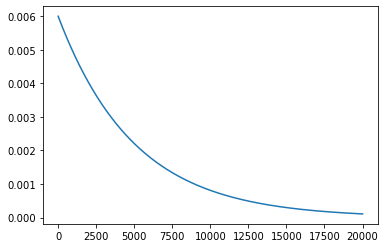

In [96]:
lr = []
start = 0.006
for i in range(20000):
    decay_factor1 = 0.9998 ** (1 + 0.000000001 * i)
    start *= decay_factor1
    lr.append(start )
    
plt.plot(lr)



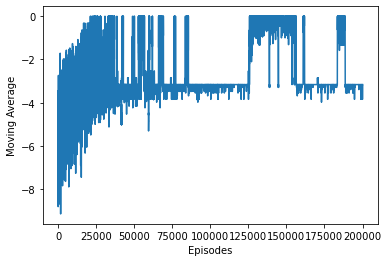

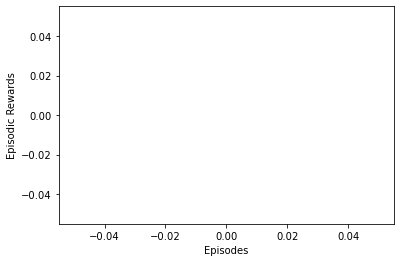

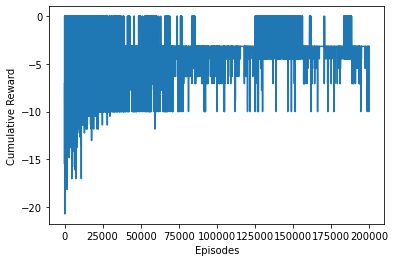

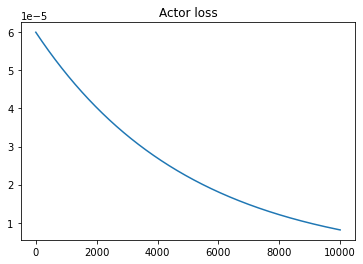

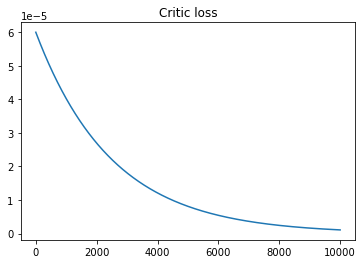

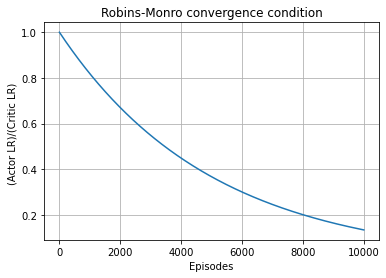

In [15]:
cum_reward_x_axis = [i for i in range(len(cumm_running_reward_list))]
ep_reward_x_axis = [i for i in range(len(episode_reward_list))]
loss_x_axis = [i for i in range(len(loss_list))]
actor_lr_x_axis = [i for i in range(len(actor_lr_list))]
critic_lr_x_axis = [i for i in range(len(critic_lr_list))]

# smoothed_rewards = moving_average(episode_reward_list, 10)
smoothed_rewards = moving_average(cumm_running_reward_list, 10)

smoothed_rewards_x_axis = [i for i in range(len(smoothed_rewards))]

plt.plot(smoothed_rewards_x_axis, smoothed_rewards)
plt.xlabel("Episodes")
plt.ylabel("Moving Average")
plt.show()

plt.plot(ep_reward_x_axis, episode_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Episodic Rewards")
plt.show()
plt.plot(cum_reward_x_axis, cumm_running_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.show()
plt.plot(actor_lr_x_axis, actor_lr_list)
plt.title("Actor loss")
plt.show()
plt.plot(critic_lr_x_axis, critic_lr_list)
plt.title("Critic loss")
plt.show()


plt.plot(critic_lr_x_axis,robins_monro_condition)
# plt.xticks(ticks=custom_x_values, labels=custom_x_labels, rotation=45, ha='right', size='small')
plt.grid(visible=True)
plt.title("Robins-Monro convergence condition")
plt.ylabel("(Actor LR)/(Critic LR) ")
plt.xlabel("Episodes")
plt.show()

In [36]:
# plot the autocorrelation function given the optimal policy

def compute_autocorrelation(series, max_lag):
    """
    Compute the autocorrelation for a range of lags.
    """
    autocorr_values = []
    n = len(series)
    mean = np.mean(series)
    
    for lag in range(1, max_lag + 1):
        numerator = np.sum((series[:n-lag] - mean) * (series[lag:] - mean))
        denominator = np.sum((series - mean)**2)
        autocorr_values.append(numerator / denominator)
    
    return autocorr_values

def plot_autocorrelation(series, max_lag):
    """
    Plot the autocorrelation graph for the given Markov chain series.
    """
    autocorr_values = compute_autocorrelation(series, max_lag)
    lags = range(1, max_lag + 1)
    
    plt.figure(figsize=(8, 6))
    plt.bar(lags, autocorr_values, width=0.5)
    plt.title("Autocorrelation of Markov Chain")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()
    
    
# print("Problem name: ", problem_name)

model = TransformerPolicy(len(initial_states[0]), action_space_size, mask_action_size, mask_rate)
model.load_state_dict(torch.load('Models/'+'policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth'))
model.eval()


step = 0
path = []
path_length = 10000

state = env.reset()
path.append(state)
done = False

# Convert dictionary values to a list of arrays
visited_states = [np.array(initial_states[0])]
visited_states = np.stack(visited_states)

#Initialize the environment.
env = Env(initial_states, # initial_state
         num_episodes, # total_episodes
         max_path_length, # show_path_num
         visited_states,  # visited_states
         available_actions, # basis_moves
         node_num, # node_num
         0, # P
         lb, #lb
         reward_list,
         reward_cost,
         )


discovered_states = []

for i in range(path_length):
    action = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, i, False, False)
    
    action_rounded = np.array(np.round(action), dtype=int)
    all_actions = [np.multiply(action_rounded[i], available_actions[i]) for i in range(len(action_rounded))]
    all_actions = np.stack(all_actions)
    action = np.sum(all_actions, 0)
    
    next_state = np.add(state, action)
    
    if all(coord >= 0 for coord in next_state):
#         if next_state.tolist() not in discovered_states:
#             discovered_states.append(next_state)
        print("#########")
        print(action)
        print(next_state)
        path.append(next_state)
#     next_state, reward, done, info = env.step(action)
    state = next_state
#     path.append(state)
    
    if i%100 == 0:
        print(f'We discovered {len(discovered_state)} states.')

print(f'Length of the path is {len(path)}')
    
plot_autocorrelation(np.array(path), max_lag=20)

We discovered 1 states.
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0  1 -1  0 -1  1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1

#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0

#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0]
[1 0 1 0 0 1 1 1 1 1]
#########
[ 0 -1  1  0  1 -1  0  0  0  0

KeyboardInterrupt: 

In [59]:
def filter_actions(state, actions, action_probabilities):
    filtered_actions = []
    filtered_actions_probs = []
    for a in range(len(actions)):
        next_state = np.add(state, actions[a])
        if all(coord >= 0 for coord in next_state):
            filtered_actions.append(actions[a])
            print("Possible action: ", actions[a], " with probability ", action_probabilities[a], " ordered at position ", a)
            filtered_actions_probs.append(action_probabilities[a])
        else:
            print("Impossible action: ", actions[a], " with probability ", action_probabilities[a], " ordered at position ", a)
    return filtered_actions, filtered_actions_probs

We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 1 unique states using the optimal stochastic policy
We discovered 2 unique states using the optimal stochastic policy
We discove

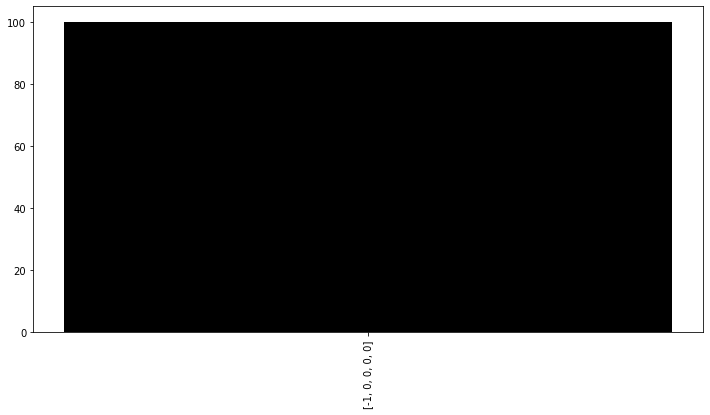

The ratio of rejected states, given random actions is: 0.0


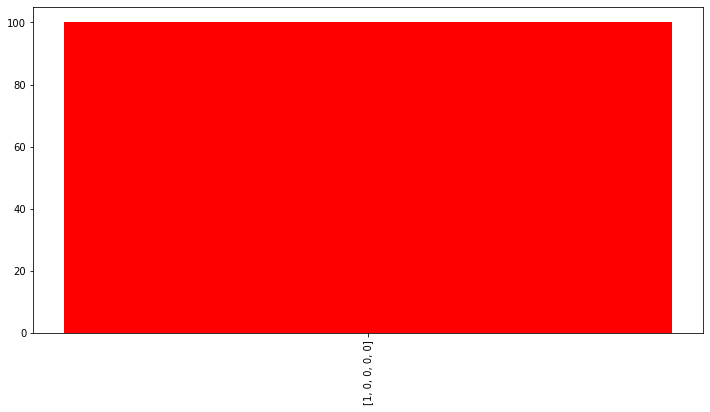

The ratio of rejected states, given random actions is: 0.99


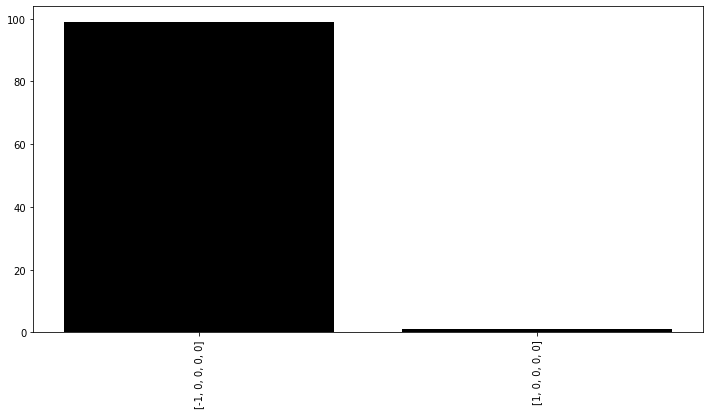

The ratio of rejected states, given random actions is: 0.0


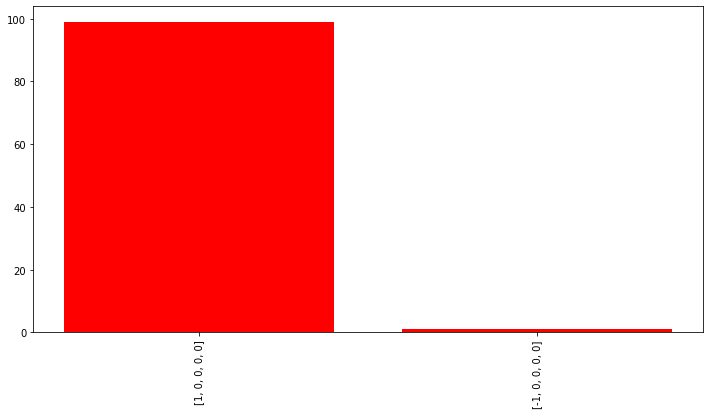

The ratio of rejected states, given random actions is: 0.99


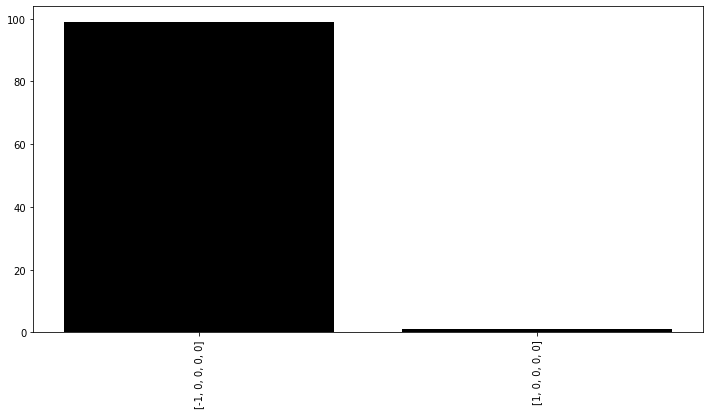

The ratio of rejected states, given random actions is: 0.0


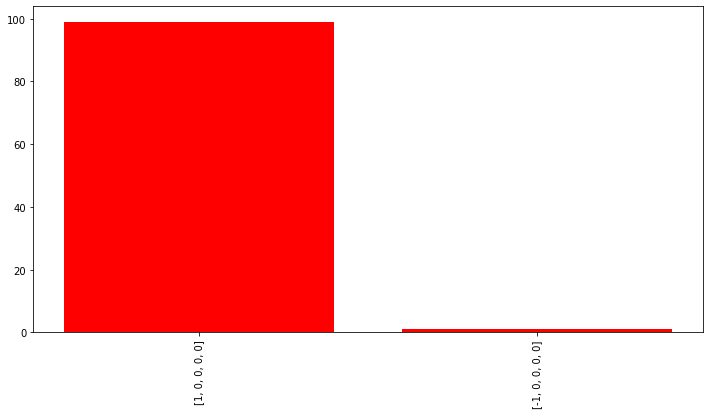

The ratio of rejected states, given random actions is: 1.0


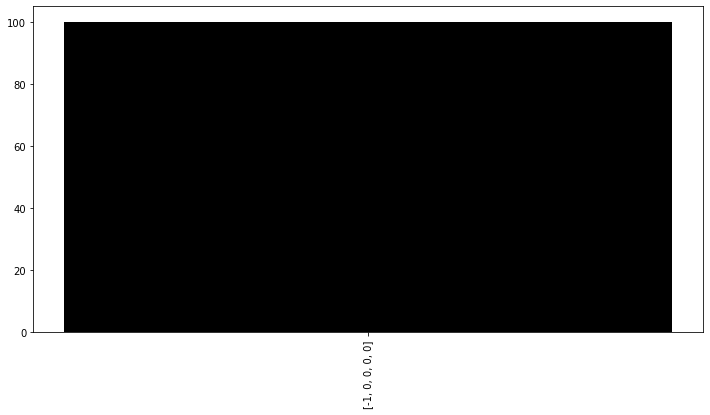

The ratio of rejected states, given random actions is: 0.01


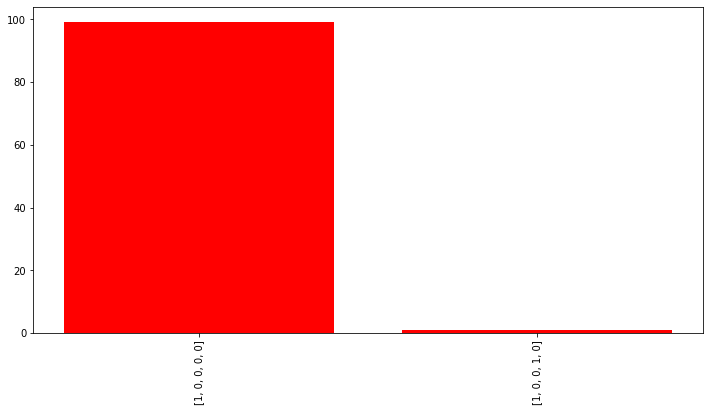

The ratio of rejected states, given random actions is: 1.0


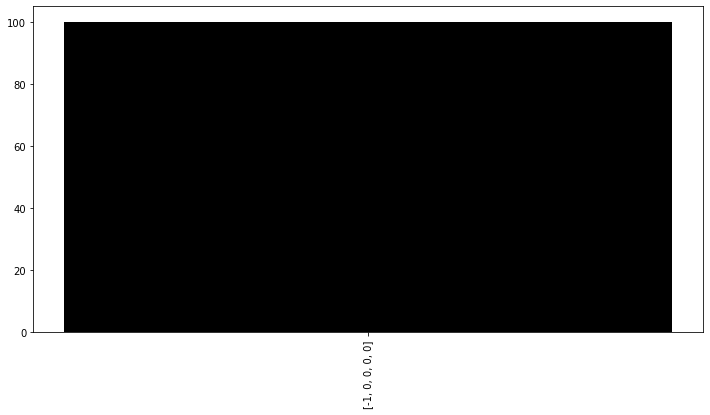

The ratio of rejected states, given random actions is: 0.02


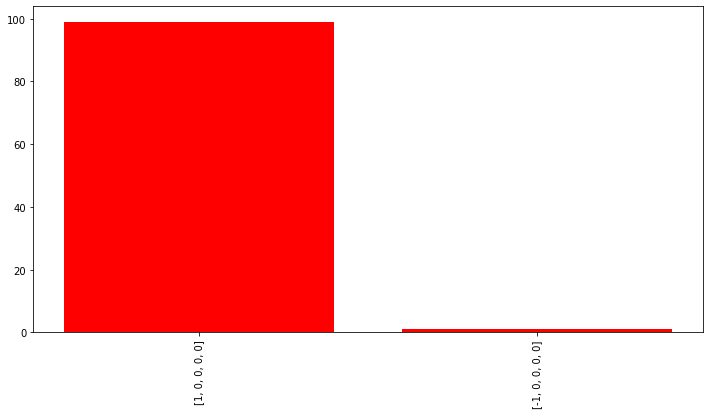

In [90]:
# Load the model 
feature_net_arch = [len(initial_states[0]), 56, 28, 12, 28]
# model = Policy(feature_net_arch, len(initial_states[0]), len(action_space_values))
model = TransformerPolicy(len(initial_states[0]), action_space_size, mask_action_size, mask_rate)
model.load_state_dict(torch.load('Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')) #+ str(node_num)
model.eval()


initial_states = {0: np.array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1])}
visited_states = [initial_states[0]]
min_rewards = []
sim_number = 100
optimum_reached = 0
max_path_length = 10

simulated_actions = {}
rejected_state_count = {}
sim_bar_colors = {}
for t in range(max_path_length):
    simulated_actions[t] = []
    rejected_state_count[t] = 0
    sim_bar_colors[t] = []
sim_frequency_dict = {}



for sim in range(sim_number):

#     print("########################################################################")
#     print("########################################################################")
#     print("########################################################################")
#     print("########################################################################")
#     print("########################################################################")
    
    frequency_dict = {}
    bar_colors = []
    
    # Convert dictionary values to a list of arrays
    visited_states = [initial_states[0]]
    visited_states = np.stack(visited_states)

    #Initialize the environment.
    env = Env(initial_states, # initial_state
             num_episodes, # total_episodes
             50, # show_path_num
             visited_states,  # visited_states
             available_actions, # basis_moves
             node_num, # node_num
             0, # P
             lb, #lb
             reward_list,
             reward_cost,
             )

    # reset environment and episode reward
    state = env.reset()
 
    # for each episode, only run 9999 steps so that we don't
    # infinite loop while learning
    for t in range(max_path_length):
        
       
#         action = select_best_action_transformer(model, state, action_space_values, t, mask_range)
        action_coeffs = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, t, False, False)
#         actions, action_probabilities = construct_stochastic_policy(model, state, SavedAction, action_space_values, mask_range, t, False, 0.01)
#         if str(action_coeffs) not in frequency_dict.keys():
#             frequency_dict[str(action_coeffs)] = 1
#         else:
#             frequency_dict[str(action_coeffs)] += 1
        simulated_actions[t].append(str(action_coeffs))
        action_rounded = np.array(np.round(action_coeffs), dtype=int)
        all_actions = [np.multiply(action_rounded[i], available_actions[i]) for i in range(len(action_rounded))]
        all_actions = np.stack(all_actions)
        action = np.sum(all_actions, 0)

        next_state = np.add(state, action)
        if all(coord >= 0 for coord in next_state):
            sim_bar_colors[t].append('red')
            if next_state.tolist() not in visited_states.tolist():
                visited_states = np.concatenate((visited_states,[next_state]),axis=0)
        else:
            rejected_state_count[t] += 1
            sim_bar_colors[t].append('black')
        
        state = next_state
    
    sim_frequency_dict[sim] = frequency_dict
    sim_bar_colors[sim] = bar_colors
    
    print(f'We discovered {visited_states.shape[0]} unique states using the optimal stochastic policy')


#     plt.figure(figsize=(14, 8))
#     plt.bar(frequency_dict.keys(), frequency_dict.values(), color=bar_colors)
#     plt.xticks(rotation=90)
#     plt.show()

for t in range(max_path_length):
    print(f'The ratio of rejected states, given random actions is: {rejected_state_count[t]/sim_number}')
    frequency_dict = Counter(simulated_actions[t])
    plt.figure(figsize=(12, 6))
    plt.bar(frequency_dict.keys(), frequency_dict.values(), color=sim_bar_colors[t]) 
    plt.xticks(rotation=90)
    plt.show()

policy_model_Node#_5_EP_2000.pth
[[1 0 1 0 1 1 0 1 0 1]
 [0 0 1 1 1 2 0 1 0 0]
 [1 0 0 1 0 2 0 2 0 0]
 [1 1 0 0 0 2 0 1 0 1]
 [0 1 0 1 0 3 0 1 0 0]
 [0 0 2 0 1 2 0 0 1 0]
 [1 0 1 0 0 2 0 1 1 0]
 [0 2 0 0 0 3 0 0 0 1]
 [0 1 1 0 1 2 0 0 0 1]
 [0 1 1 0 0 3 0 0 1 0]
 [2 0 0 0 0 1 0 2 0 1]
 [1 0 1 0 0 1 1 2 0 0]
 [0 1 1 0 0 2 1 1 0 0]
 [0 0 2 0 2 1 0 0 0 1]
 [0 0 2 0 1 1 1 1 0 0]]
[12  1  4  8  3]
State:  [0 1 1 0 0 2 1 1 0 0]
State:  [0 0 1 1 1 2 0 1 0 0]
State:  [0 1 0 1 0 3 0 1 0 0]
State:  [0 1 1 0 1 2 0 0 0 1]
State:  [1 1 0 0 0 2 0 1 0 1]
The ratio of rejected states, given random actions is: 1.0


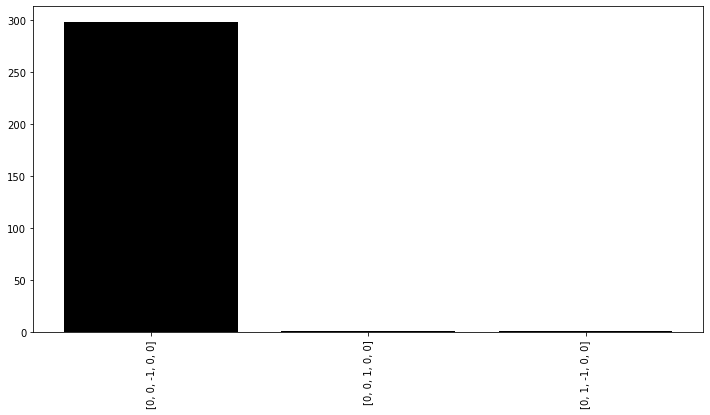

The ratio of rejected states, given random actions is: 0.9466666666666667


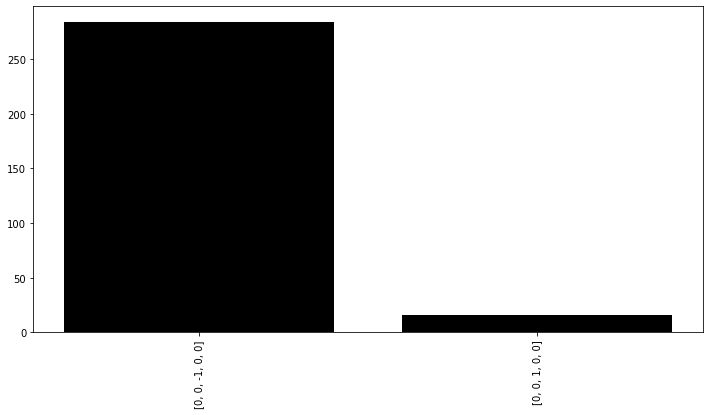

The ratio of rejected states, given random actions is: 1.0


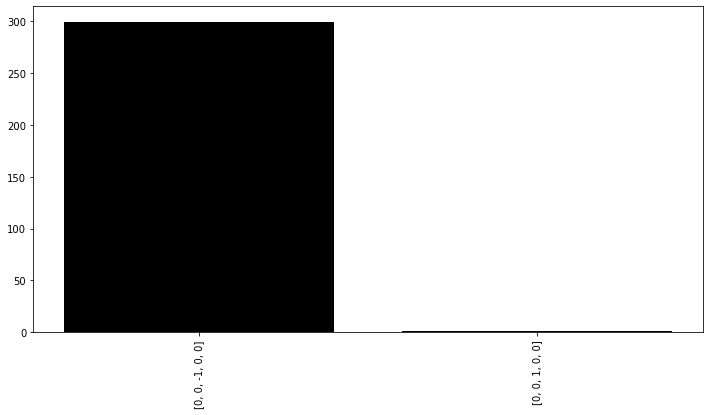

The ratio of rejected states, given random actions is: 0.0033333333333333335


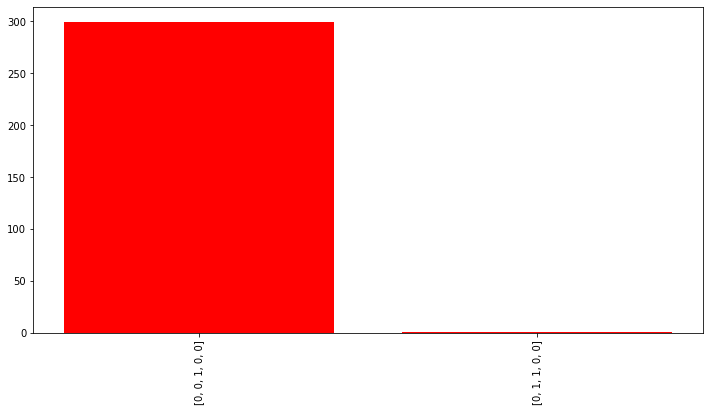

The ratio of rejected states, given random actions is: 0.0


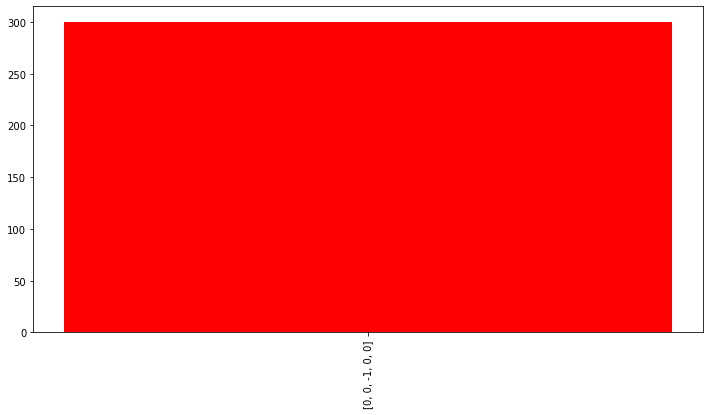

In [111]:

# Load the model 
feature_net_arch = [len(initial_states[0]), 56, 28, 12, 28]
# model = Policy(feature_net_arch, len(initial_states[0]), len(action_space_values))
model = TransformerPolicy(len(initial_states[0]), action_space_size, mask_action_size, mask_rate)
print('policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')
model.load_state_dict(torch.load('Models/policy_model_Node#_' + str(node_num) + "_EP_" + str(num_episodes) +  '.pth')) #+ str(node_num)
model.eval()


initial_states = {0: np.array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1])}
visited_states = np.load('Data' + os.sep + 'visited_states_EP_'+str(num_episodes) + '_P_'+str(100)+'.npy')
print(visited_states)
min_rewards = []
sim_number = 300
optimum_reached = 0


simulated_actions = {}
rejected_state_count = {}
sim_bar_colors = {}


# state_indx = np.random.randint(visited_states.shape[0], size = 5)
state_indx = np.random.choice(visited_states.shape[0], size=5, replace=False)
print(state_indx)
for s in state_indx:
    simulated_actions[s] = []
    rejected_state_count[s] = 0
    sim_bar_colors[s] = []

for s in state_indx:
    state = visited_states[s,:]
    print("State: ", state)
    frequency_dict = {}
    bar_colors = []
    
    for sim in range(sim_number):
        action_coeffs = select_action_transformer(model, state, SavedAction, action_space_values, mask_range, 0, False, False)
        simulated_actions[s].append(str(action_coeffs))
        action_rounded = np.array(np.round(action_coeffs), dtype=int)
        all_actions = [np.multiply(action_rounded[i], available_actions[i]) for i in range(len(action_rounded))]
        all_actions = np.stack(all_actions)
        action = np.sum(all_actions, 0)
   
        next_state = np.add(state, action)
        if all(coord >= 0 for coord in next_state):
            sim_bar_colors[s].append('red')
        else:
            rejected_state_count[s] += 1
            sim_bar_colors[s].append('black')


for s in state_indx:
    
    print(f'The ratio of rejected states, given random actions is: {rejected_state_count[s]/sim_number}')
    frequency_dict = Counter(simulated_actions[s])
    plt.figure(figsize=(12, 6))
    plt.bar(frequency_dict.keys(), frequency_dict.values(),color=sim_bar_colors[s] ) 
    plt.xticks(rotation=90)
    plt.show()